Precomputing C(s)...
  done in 0.02 s
C_s sample: [4.81158198+0.j         3.17083807-0.99668298j 2.63755619-0.97166998j
 2.40792313-0.90948696j 2.23807085-0.92452111j]
Precomputing xi(zeta,t)...
  done in 0.00 s
xi(omega0) sample: [0.        +0.j         0.67759887-0.03804408j 1.18787166-0.08044091j
 1.63594402-0.05464881j 2.04377671+0.03089576j]
Starting mesolve with H(t) ...
mesolve done in 7.79 s


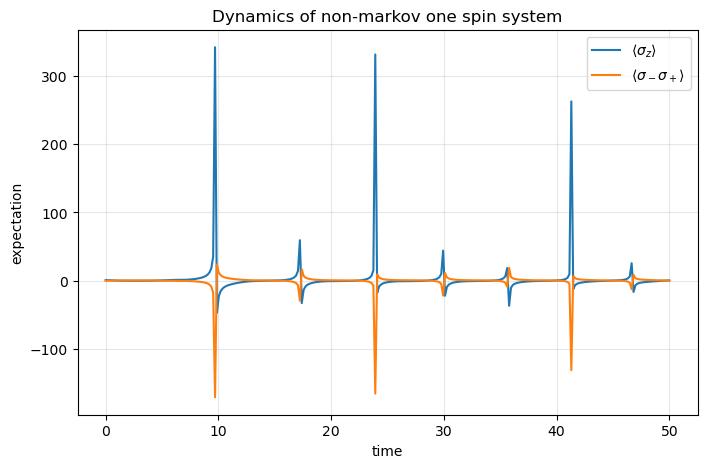

In [2]:
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
import qutip as qt
import matplotlib.pyplot as plt
import time

omega_0 = 1.0
theta = 0.1
T = 1.0

m_val = 1.0
gamma_val = 1.0
Omega_val = 1.0

t_max = 50.0
n_t = 300
s_grid = np.linspace(0.0, t_max, n_t)
times = s_grid.copy()
omega_max = 50.0
n_omega = 600
omega_min = 1e-9
omega_grid = np.linspace(omega_min, omega_max, n_omega)

def J_lorentz(omega, m=m_val, gamma=gamma_val, Omega=Omega_val):
    return (2.0 * m * gamma * omega * Omega**2) / (np.pi * (omega**2 + Omega**2))

def coth(x):
    x = np.asarray(x, dtype=float)
    out = np.empty_like(x)
    small = np.abs(x) < 1e-8
    out[~small] = np.cosh(x[~small]) / np.sinh(x[~small])
    if np.any(small):
        xs = x[small]
        eps = 1e-30
        out[small] = 1.0 / (xs + eps) + xs / 3.0
    return out

L0 = (4.0 * m_val * gamma_val * T) / np.pi

print("Precomputing C(s)..."); t0 = time.time()
J_vals = J_lorentz(omega_grid)
coth_vals = coth(omega_grid / (2.0 * T))

omega_col = omega_grid[:, None]
s_row = s_grid[None, :]
cos_mat = np.cos(omega_col * s_row)
sin_mat = np.sin(omega_col * s_row)

integrand = (J_vals * coth_vals)[:, None] * (cos_mat - 1j * sin_mat)
C_s = np.trapezoid(integrand, x=omega_grid, axis=0)
C_s += L0

print(f"  done in {time.time() - t0:.2f} s")
print("C_s sample:", C_s[:5])

print("Precomputing xi(zeta,t)..."); t0 = time.time()
zetas = [0.0, omega_0, -omega_0]
xi_table = {}
for z in zetas:
    integrand_s = np.exp(1j * z * s_grid) * C_s
    xi_vals = cumulative_trapezoid(integrand_s, x=s_grid, initial=0.0)
    xi_table[z] = xi_vals
print(f"  done in {time.time() - t0:.2f} s")
print("xi(omega0) sample:", xi_table[omega_0][:5])

xi_interp = {}
for z in zetas:
    vals = xi_table[z]
    xi_interp[z] = {
        're': interp1d(s_grid, np.real(vals), kind='linear', fill_value='extrapolate', assume_sorted=True),
        'im': interp1d(s_grid, np.imag(vals), kind='linear', fill_value='extrapolate', assume_sorted=True)
    }

def xi_cached(zeta, t):
    re = xi_interp[zeta]['re'](t)
    im = xi_interp[zeta]['im'](t)
    return re + 1j * im

sigmas = [qt.sigmap(), qt.sigmam(), qt.sigmaz()]

def make_gamma_functions():
    g = [[None]*3 for _ in range(3)]
    g[0][0] = lambda t, args: 0.5 * np.cos(args['theta'])**2 * np.real(xi_cached(-args['omega_0'], t))
    g[0][1] = lambda t, args: 0.25 * np.cos(args['theta'])**2 * (xi_cached(-args['omega_0'], t) + np.conj(xi_cached(args['omega_0'], t)))
    g[1][0] = lambda t, args: np.conj(g[0][1](t, args))
    g[1][1] = lambda t, args: 0.5 * np.sin(args['theta'])**2 * np.real(xi_cached(args['omega_0'], t))
    g[2][1] = lambda t, args: 0.25 * np.sin(args['theta'])*np.cos(args['theta']) * (xi_cached(0.0, t) + np.conj(xi_cached(args['omega_0'], t)))
    g[1][2] = lambda t, args: np.conj(g[2][1](t, args))
    g[2][0] = lambda t, args: 0.25 * np.sin(args['theta'])*np.cos(args['theta']) * (xi_cached(0.0, t) + np.conj(xi_cached(-args['omega_0'], t)))
    g[0][2] = lambda t, args: np.conj(g[2][0](t, args))
    g[2][2] = lambda t, args: 0.5 * np.sin(args['theta'])**2 * np.real(xi_cached(0.0, t))
    return g

gamma = make_gamma_functions()

d_ops = []
for i in range(3):
    for j in range(3):
        gij = gamma[i][j]
        if gij is None:
            continue
        op_ij = qt.lindblad_dissipator(sigmas[i], sigmas[j].dag())
        d_ops.append([op_ij, gij])

def H_LS_matrix_elements(t, args):
    th = args['theta']
    om0 = args['omega_0']
    xi_m = xi_cached(-om0, t)
    xi_p = xi_cached( om0, t)
    xi_0 = xi_cached(0.0, t)

    H00 = 0.25 * (np.cos(th)**4) * np.imag(xi_p)
    H11 = 0.25 * (np.cos(th)**4) * np.imag(xi_m)
    bracket = np.real(xi_0) - 0.5 * (np.conj(xi_m) + xi_p)
    H01 = -1j * 0.25 * np.cos(th) * np.sin(th) * bracket

    return H00, H01, H11

H_s = 0.5 * omega_0 * qt.sigmaz()
def H_total_t(t, args):
    H00, H01, H11 = H_LS_matrix_elements(t, args)
    H_LS_q = qt.Qobj([[H00, H01],
                      [np.conj(H01), H11]])
    return H_s + H_LS_q

psi0 = qt.basis(2, 0)
tlist = times

print("Starting mesolve with H(t) ..."); t_start = time.time()
res = qt.mesolve(
    H_total_t,
    psi0,
    tlist,
    d_ops,
    e_ops=[qt.sigmaz(), qt.sigmam()*qt.sigmap()],
    args={'theta': theta, 'omega_0': omega_0}
)
print(f"mesolve done in {time.time() - t_start:.2f} s")

plt.figure(figsize=(8,5))
plt.plot(tlist, np.real(res.expect[0]), label=r'$\langle\sigma_z\rangle$')
plt.plot(tlist, np.real(res.expect[1]), label=r'$\langle \sigma_- \sigma_+ \rangle$')
plt.xlabel("time")
plt.ylabel("expectation")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Dynamics of non-markov one spin system")
plt.show()